In [1]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Rest of code follows ...

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras

In [3]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.optimizers import Adam, SGD
import numpy as np
from keras.models import load_model
from keras.utils.np_utils import to_categorical
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint

In [4]:
import itertools
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import confusion_matrix

In [5]:
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues, normalise=False, title='Confusion matrix'):
    cm = confusion_matrix(y_true, y_pred)
    if normalise:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
    fig = plt.figure(figsize=(7,7))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(class_names))
    ax.set_xticks(ticks)
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

In [6]:
# load data
X_train=np.load('images_train.npy')
y_train=np.load('emotions_train.npy')
y_train=to_categorical(y_train)

X_val=np.load('images_val.npy')
y_val=np.load('emotions_val.npy')
y_val=to_categorical(y_val)

X_test=np.load('images_test.npy')
y_test=np.load('emotions_test.npy')
y_test=to_categorical(y_test)

In [7]:
from skimage import data, img_as_float
from skimage import exposure

for i in range(len(X_train)):
    image = X_train[i]
    X_train[i]=exposure.equalize_adapthist(image, clip_limit=0.99)

for i in range(len(X_val)):
    image = X_val[i]
    X_val[i]=exposure.equalize_adapthist(image, clip_limit=0.99)

for i in range(len(X_test)):
    image = X_test[i]
    X_test[i]=exposure.equalize_adapthist(image, clip_limit=0.99)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint16.
  .format(dtypeobj_in, dtypeobj_out))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 210 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 219 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 255 fits in uint16
  "value {} fits in {

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 215 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 231 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 240 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 139 fits in uint16
  "value {} 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 194 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 191 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 209 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 229 fits in uint16
  "value {} 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 127 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 165 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 159 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 141 fits in uint16
  "value {} 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 81 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 110 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 135 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 143 fits in uint16
  "value {} f

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 114 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 84 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 125 fits in uint16
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:171: UserWarning: Downcasting int64 to uint16 without scaling because max value 90 fits in uint16
  "value {} fi

In [9]:
X_train=X_train.reshape(-1, 1, X_train.shape[1], X_train.shape[2])
X_val=X_val.reshape(-1, 1, X_val.shape[1], X_val.shape[2])
X_test=X_test.reshape(-1, 1, X_test.shape[1], X_test.shape[2])

In [10]:
class_names= ['Angry', 'Disgust', 'Fear', 'Happy','Sad', 'Surprise', 'Neutral']

In [11]:
# parameters:
batch_size = 128
epochs = 100

In [12]:
# setup info:
print ('X_train shape: ', X_train.shape) # (n_sample, 1, 48, 48)
print ('y_train shape: ', y_train.shape) # (n_sample, n_categories)
print ('X_val shape: ', X_val.shape) # (n_sample, 1, 48, 48)
print ('y_val shape: ', y_val.shape) # (n_sample, n_categories)
print ('X_test shape: ', X_test.shape) # (n_sample, 1, 48, 48)
print ('y_test shape: ', y_test.shape) # (n_sample, n_categories)
print ('  img size: ', X_train.shape[2], X_train.shape[3])
print ('batch size: ', batch_size)
print ('  nb_epoch: ', epochs)
print ('classes: ', class_names)

X_train shape:  (28709, 1, 48, 48)
y_train shape:  (28709, 7)
X_val shape:  (3589, 1, 48, 48)
y_val shape:  (3589, 7)
X_test shape:  (3589, 1, 48, 48)
y_test shape:  (3589, 7)
  img size:  48 48
batch size:  128
  nb_epoch:  100
classes:  ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


In [13]:
model=load_model('clahe.h5')

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 48, 48)        320       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 48, 48)        9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 24, 24)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 24, 24)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 24, 24)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 12, 12)        0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 128, 12, 12)       73856     
__________

In [15]:
y_pred=model.predict(X_test, batch_size=batch_size, verbose=1, steps=None)

3589/3589 [==============================] - 221s 62ms/step


In [16]:
y_pred_prob=[np.argmax(prob) for prob in y_pred]
y_true = [np.argmax(true) for true in y_test]

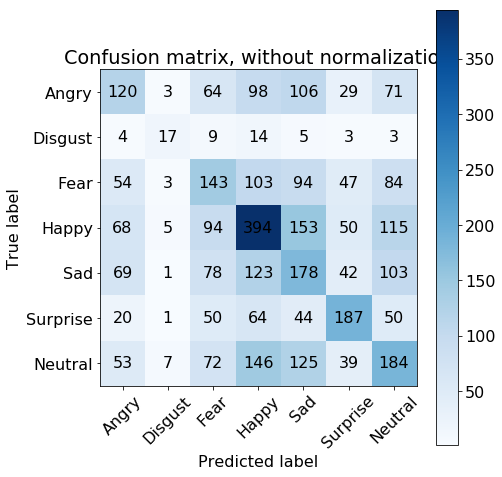

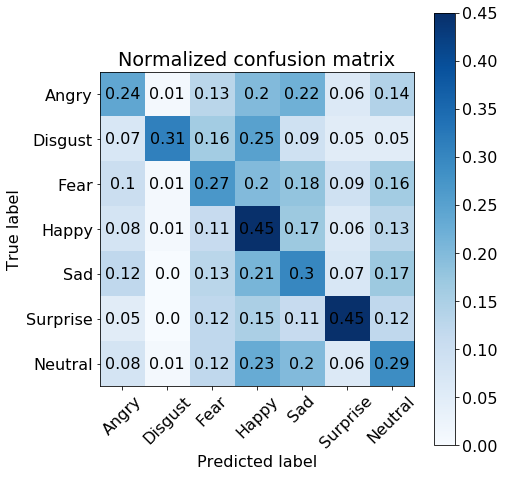

In [17]:
cf_mx=plot_confusion_matrix(y_true, y_pred_prob, title='Confusion matrix, without normalization')
cf_mx_norm=plot_confusion_matrix(y_true, y_pred_prob, normalise=True,title='Normalized confusion matrix')